# Tensorflow.keras implementation of full precision shifted ReLU CNN for CIFAR 10
##  https://arxiv.org/abs/1907.06916
## Mark D. McDonnell, Hesham Mostafa, Runchun Wang, Andre van Schaik,
## Single-bit-per-weight deep convolutional neural networks without batch-normalization layers for embedded systems

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet_srelu
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
WhichDataSet = 'CIFAR10'
#WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 300
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')#/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
def catcross_entropy_logits_loss():
    def loss(y_true, y_pred):
        return tensorflow.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss

In [7]:
#define a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
Temperature=80.0
model = resnet_srelu(Temperature,UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,
                     wd=My_wd,width=resnet_width)
model.compile(loss=catcross_entropy_logits_loss() ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 160)  4320        batch_normalization_v1_1[0][0]   
__________________________________________________________________________________________________
lambda_41 (Lambda)              (None, 32, 32, 160)  0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
re_lu_19 (

In [8]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)


 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 7s 732us/sample - loss: 4.0340 - acc: 0.3872

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 117s 291ms/step - loss: 4.9153 - acc: 0.2461 - val_loss: 4.0340 - val_acc: 0.3872

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 7s 711us/sample - loss: 2.9530 - acc: 0.5267

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 116s 289ms/step - loss: 3.5469 - acc: 0.4304 - val_loss: 2.9530 - val_acc: 0.5267

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 7s 696us/sample - loss: 2.1806 - acc: 0.6481

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 115s 288ms/step - loss: 2.6641 - acc: 0.5507 - val_loss: 2.1806 - val_acc: 0.6481

 Start of Epoch Learning Rate = 0.099975
Epoch 4/300
10000/10000 [

10000/10000 [==============================] - 7s 715us/sample - loss: 0.8353 - acc: 0.8842

 End of Epoch Learning Rate = 0.098015
400/400 [==============================] - 116s 290ms/step - loss: 0.8792 - acc: 0.8635 - val_loss: 0.8353 - val_acc: 0.8842

 Start of Epoch Learning Rate = 0.098015
Epoch 28/300
10000/10000 [==============================] - 7s 710us/sample - loss: 0.8041 - acc: 0.8912

 End of Epoch Learning Rate = 0.097866
400/400 [==============================] - 115s 288ms/step - loss: 0.8822 - acc: 0.8637 - val_loss: 0.8041 - val_acc: 0.8912

 Start of Epoch Learning Rate = 0.097866
Epoch 29/300
10000/10000 [==============================] - 7s 725us/sample - loss: 0.8596 - acc: 0.8757

 End of Epoch Learning Rate = 0.097712
400/400 [==============================] - 115s 288ms/step - loss: 0.8893 - acc: 0.8612 - val_loss: 0.8596 - val_acc: 0.8757

 Start of Epoch Learning Rate = 0.097712
Epoch 30/300
10000/10000 [==============================] - 7s 705us/sample -

10000/10000 [==============================] - 7s 717us/sample - loss: 0.7937 - acc: 0.9049

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 115s 287ms/step - loss: 0.8566 - acc: 0.8797 - val_loss: 0.7937 - val_acc: 0.9049

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 7s 710us/sample - loss: 0.8261 - acc: 0.9000

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 115s 288ms/step - loss: 0.8429 - acc: 0.8831 - val_loss: 0.8261 - val_acc: 0.9000

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 7s 712us/sample - loss: 0.8204 - acc: 0.8981

 End of Epoch Learning Rate = 0.091934
400/400 [==============================] - 115s 288ms/step - loss: 0.8372 - acc: 0.8850 - val_loss: 0.8204 - val_acc: 0.8981

 Start of Epoch Learning Rate = 0.091934
Epoch 56/300
10000/10000 [==============================] - 7s 708us/sample -

10000/10000 [==============================] - 7s 710us/sample - loss: 0.7818 - acc: 0.9022

 End of Epoch Learning Rate = 0.083845
400/400 [==============================] - 115s 287ms/step - loss: 0.8056 - acc: 0.8906 - val_loss: 0.7818 - val_acc: 0.9022

 Start of Epoch Learning Rate = 0.083845
Epoch 80/300
10000/10000 [==============================] - 7s 720us/sample - loss: 0.7479 - acc: 0.9182

 End of Epoch Learning Rate = 0.083458
400/400 [==============================] - 115s 288ms/step - loss: 0.7973 - acc: 0.8958 - val_loss: 0.7479 - val_acc: 0.9182

 Start of Epoch Learning Rate = 0.083458
Epoch 81/300
10000/10000 [==============================] - 7s 716us/sample - loss: 0.7751 - acc: 0.9045

 End of Epoch Learning Rate = 0.083067
400/400 [==============================] - 115s 288ms/step - loss: 0.7822 - acc: 0.8984 - val_loss: 0.7751 - val_acc: 0.9045

 Start of Epoch Learning Rate = 0.083067
Epoch 82/300
10000/10000 [==============================] - 7s 713us/sample -

10000/10000 [==============================] - 7s 700us/sample - loss: 0.7020 - acc: 0.9230

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 116s 290ms/step - loss: 0.7333 - acc: 0.9060 - val_loss: 0.7020 - val_acc: 0.9230

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 7s 702us/sample - loss: 0.7053 - acc: 0.9223

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 116s 289ms/step - loss: 0.7361 - acc: 0.9049 - val_loss: 0.7053 - val_acc: 0.9223

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 7s 705us/sample - loss: 0.7237 - acc: 0.9145

 End of Epoch Learning Rate = 0.071764
400/400 [==============================] - 115s 288ms/step - loss: 0.7320 - acc: 0.9074 - val_loss: 0.7237 - val_acc: 0.9145

 Start of Epoch Learning Rate = 0.071764
Epoch 108/300
10000/10000 [==============================] - 7s 722us/sampl

10000/10000 [==============================] - 7s 696us/sample - loss: 0.6935 - acc: 0.9159

 End of Epoch Learning Rate = 0.059887
400/400 [==============================] - 114s 285ms/step - loss: 0.6496 - acc: 0.9212 - val_loss: 0.6935 - val_acc: 0.9159

 Start of Epoch Learning Rate = 0.059887
Epoch 132/300
10000/10000 [==============================] - 7s 705us/sample - loss: 0.6583 - acc: 0.9231

 End of Epoch Learning Rate = 0.059373
400/400 [==============================] - 114s 286ms/step - loss: 0.6570 - acc: 0.9184 - val_loss: 0.6583 - val_acc: 0.9231

 Start of Epoch Learning Rate = 0.059373
Epoch 133/300
10000/10000 [==============================] - 7s 712us/sample - loss: 0.7369 - acc: 0.9050

 End of Epoch Learning Rate = 0.058858
400/400 [==============================] - 115s 287ms/step - loss: 0.6511 - acc: 0.9190 - val_loss: 0.7369 - val_acc: 0.9050

 Start of Epoch Learning Rate = 0.058858
Epoch 134/300
10000/10000 [==============================] - 7s 698us/sampl

10000/10000 [==============================] - 7s 702us/sample - loss: 0.6201 - acc: 0.9228

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 114s 284ms/step - loss: 0.5621 - acc: 0.9351 - val_loss: 0.6201 - val_acc: 0.9228

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 7s 694us/sample - loss: 0.6161 - acc: 0.9217

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 114s 286ms/step - loss: 0.5581 - acc: 0.9358 - val_loss: 0.6161 - val_acc: 0.9217

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 7s 706us/sample - loss: 0.5951 - acc: 0.9259

 End of Epoch Learning Rate = 0.045300
400/400 [==============================] - 115s 287ms/step - loss: 0.5493 - acc: 0.9375 - val_loss: 0.5951 - val_acc: 0.9259

 Start of Epoch Learning Rate = 0.045300
Epoch 160/300
10000/10000 [==============================] - 7s 704us/sampl

10000/10000 [==============================] - 7s 702us/sample - loss: 0.5210 - acc: 0.9397

 End of Epoch Learning Rate = 0.033070
400/400 [==============================] - 115s 287ms/step - loss: 0.4698 - acc: 0.9486 - val_loss: 0.5210 - val_acc: 0.9397

 Start of Epoch Learning Rate = 0.033070
Epoch 184/300
10000/10000 [==============================] - 7s 698us/sample - loss: 0.5450 - acc: 0.9333

 End of Epoch Learning Rate = 0.032578
400/400 [==============================] - 115s 286ms/step - loss: 0.4644 - acc: 0.9495 - val_loss: 0.5450 - val_acc: 0.9333

 Start of Epoch Learning Rate = 0.032578
Epoch 185/300
10000/10000 [==============================] - 7s 699us/sample - loss: 0.5313 - acc: 0.9379

 End of Epoch Learning Rate = 0.032088
400/400 [==============================] - 115s 287ms/step - loss: 0.4639 - acc: 0.9494 - val_loss: 0.5313 - val_acc: 0.9379

 Start of Epoch Learning Rate = 0.032088
Epoch 186/300
10000/10000 [==============================] - 7s 700us/sampl

10000/10000 [==============================] - 7s 717us/sample - loss: 0.4675 - acc: 0.9423

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 115s 288ms/step - loss: 0.3818 - acc: 0.9611 - val_loss: 0.4675 - val_acc: 0.9423

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 7s 708us/sample - loss: 0.4654 - acc: 0.9431

 End of Epoch Learning Rate = 0.020619
400/400 [==============================] - 115s 288ms/step - loss: 0.3740 - acc: 0.9623 - val_loss: 0.4654 - val_acc: 0.9431

 Start of Epoch Learning Rate = 0.020619
Epoch 211/300
10000/10000 [==============================] - 7s 708us/sample - loss: 0.4631 - acc: 0.9431

 End of Epoch Learning Rate = 0.020197
400/400 [==============================] - 115s 288ms/step - loss: 0.3739 - acc: 0.9612 - val_loss: 0.4631 - val_acc: 0.9431

 Start of Epoch Learning Rate = 0.020197
Epoch 212/300
10000/10000 [==============================] - 7s 712us/sampl

10000/10000 [==============================] - 7s 698us/sample - loss: 0.4209 - acc: 0.9479

 End of Epoch Learning Rate = 0.011152
400/400 [==============================] - 115s 287ms/step - loss: 0.2979 - acc: 0.9742 - val_loss: 0.4209 - val_acc: 0.9479

 Start of Epoch Learning Rate = 0.011152
Epoch 236/300
10000/10000 [==============================] - 7s 695us/sample - loss: 0.4140 - acc: 0.9488

 End of Epoch Learning Rate = 0.010824
400/400 [==============================] - 115s 287ms/step - loss: 0.2927 - acc: 0.9752 - val_loss: 0.4140 - val_acc: 0.9488

 Start of Epoch Learning Rate = 0.010824
Epoch 237/300
10000/10000 [==============================] - 7s 699us/sample - loss: 0.4092 - acc: 0.9483

 End of Epoch Learning Rate = 0.010501
400/400 [==============================] - 115s 287ms/step - loss: 0.2923 - acc: 0.9751 - val_loss: 0.4092 - val_acc: 0.9483

 Start of Epoch Learning Rate = 0.010501
Epoch 238/300
10000/10000 [==============================] - 7s 698us/sampl

10000/10000 [==============================] - 7s 720us/sample - loss: 0.3735 - acc: 0.9522

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 115s 287ms/step - loss: 0.2380 - acc: 0.9825 - val_loss: 0.3735 - val_acc: 0.9522

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 7s 698us/sample - loss: 0.3771 - acc: 0.9529

 End of Epoch Learning Rate = 0.003916
400/400 [==============================] - 115s 287ms/step - loss: 0.2356 - acc: 0.9834 - val_loss: 0.3771 - val_acc: 0.9529

 Start of Epoch Learning Rate = 0.003916
Epoch 263/300
10000/10000 [==============================] - 7s 691us/sample - loss: 0.3614 - acc: 0.9526

 End of Epoch Learning Rate = 0.003716
400/400 [==============================] - 114s 286ms/step - loss: 0.2322 - acc: 0.9843 - val_loss: 0.3614 - val_acc: 0.9526

 Start of Epoch Learning Rate = 0.003716
Epoch 264/300
10000/10000 [==============================] - 7s 705us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 7s 694us/sample - loss: 0.3445 - acc: 0.9552

 End of Epoch Learning Rate = 0.000341
400/400 [==============================] - 114s 286ms/step - loss: 0.2082 - acc: 0.9879 - val_loss: 0.3445 - val_acc: 0.9552

 Start of Epoch Learning Rate = 0.000341
Epoch 290/300
10000/10000 [==============================] - 7s 695us/sample - loss: 0.3496 - acc: 0.9552

 End of Epoch Learning Rate = 0.000284
400/400 [==============================] - 114s 286ms/step - loss: 0.2057 - acc: 0.9892 - val_loss: 0.3496 - val_acc: 0.9552

 Start of Epoch Learning Rate = 0.000284
Epoch 291/300
10000/10000 [==============================] - 7s 705us/sample - loss: 0.3493 - acc: 0.9554

 End of Epoch Learning Rate = 0.000232
400/400 [==============================] - 115s 286ms/step - loss: 0.2051 - acc: 0.9898 - val_loss: 0.3493 - val_acc: 0.9554

 Start of Epoch Learning Rate = 0.000232
Epoch 292/300
10000/10000 [==============================] - 7s 702us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
#get final performance

y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 95.66


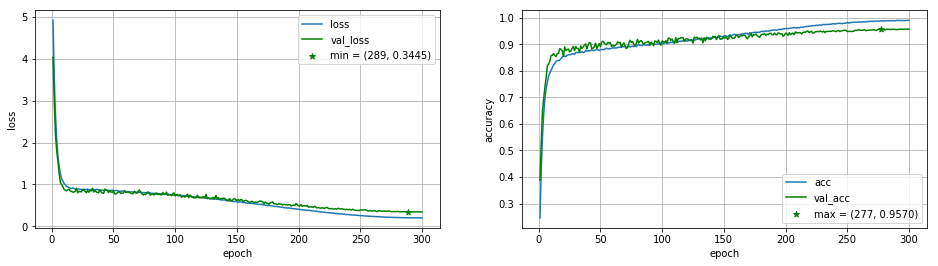

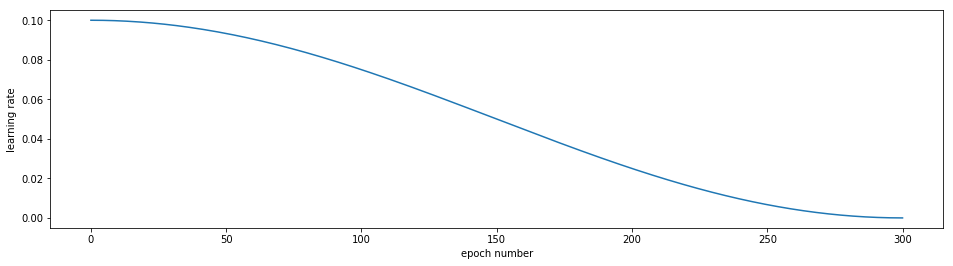

In [10]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [11]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_32bit_model_sReLU.h5')